In [2]:
pip install kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [5]:
ROOT='/content/drive/MyDrive/Store_Sales_Prediction/Jupyter Notebooks'
os.chdir(ROOT)
os.getcwd()

'/content/drive/MyDrive/Internship/Store Sales Prediction/Store_Sales_Prediction/Jupyter Notebooks'

In [7]:
train=pd.read_csv('Train.csv')
x=train.drop(columns=['Item_Outlet_Sales'])
y=train['Item_Outlet_Sales']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=100)

# Clustering

In [8]:
def create_cluster(data):
    wcss=[]
    for i in range(1,11):
        kmeans=KMeans(n_clusters=i, init='k-means++',random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    if not os.path.isdir('preprocessing_data'):
        os.mkdir('preprocessing_data')
    plt.plot(range(1,11),wcss) # creating the graph between WCSS and the number of clusters
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.savefig('preprocessing_data/K-Means_Elbow.PNG') 
    
    kn = KneeLocator(range(1, 11), wcss, curve='convex', direction='decreasing')
    total_clusters=kn.knee
    kmeans_final=KMeans(n_clusters=total_clusters, init='k-means++',random_state=42)
    clusters=kmeans_final.fit_predict(data)
    data['Cluster']=clusters
    
    if not os.path.isdir('Clustering'):
        os.mkdir('Clustering')
    pickle.dump(kmeans_final, open('Clustering/cluster.pickle', 'wb'))
    return data

# Training Pipeline

In [9]:
def train_preprocessing_pipeline(x_train, y_train):
    data=pd.concat([x_train, y_train], axis=1)
    data=data.reset_index(drop=True)
    #dropping unnecessary column
    data=data.drop(columns=['Item_Type'])
    
    #editing dataset
    data['Item_Visibility'].replace(0, np.nan, inplace=True)
    
    data['Item_Fat_Content'].replace('low fat', 'Low Fat', inplace=True)
    data['Item_Fat_Content'].replace('LF', 'Low Fat', inplace=True)
    data['Item_Fat_Content'].replace('reg', 'Low Fat', inplace=True)
    
    data['Item_Identifier']=data['Item_Identifier'].apply(lambda x : x[:2])
    
    data['Outlet_Age']=2013-data['Outlet_Establishment_Year']
    data=data.drop(columns=['Outlet_Establishment_Year'])
    
    data.loc[data['Item_Identifier']=="NC",'Item_Fat_Content']='Non Edible'
    
    #encoding categorical values
    data['Outlet_Size']=data['Outlet_Size'].map({'Small':0, 'Medium': 1, 'High': 2})
    
    onehot_col=['Item_Identifier', 'Item_Fat_Content',  'Outlet_Identifier', 'Outlet_Type', 'Outlet_Location_Type']
    onehot_enc=OneHotEncoder(drop="first", sparse=False)
    enc_array=onehot_enc.fit_transform(data[onehot_col])
    enc_df=pd.DataFrame(enc_array, columns=onehot_enc.get_feature_names_out())
    data=data.drop(columns=onehot_col)
    data=pd.concat([data, enc_df], axis=1)
    if not os.path.isdir('Encoding'):
        os.mkdir('Encoding')
    pickle.dump(onehot_enc, open('Encoding/encoder.pickle', 'wb'))
    
    #imputing missing value
    imputer=KNNImputer(n_neighbors=3, weights='uniform',missing_values=np.nan)
    new_array=imputer.fit_transform(data) # impute the missing values
    data=pd.DataFrame(data=new_array, columns=data.columns)
    data['Outlet_Size']=np.round(data['Outlet_Size'])
    
    #scaling numerical values
    num_cols=['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Age']
    num_df=data[num_cols]
    cat_output_df=data.drop(columns=num_cols) #categorical and output columns
    scaler=StandardScaler()
    num_array=scaler.fit_transform(num_df)
    num_df=pd.DataFrame(num_array, columns=num_df.columns)
    if not os.path.isdir('Scaling'):
        os.mkdir('Scaling')
    pickle.dump(scaler, open('Scaling/scaler.pickle', 'wb'))
    data=pd.concat([num_df, cat_output_df], axis=1)
    
    #clustering
    x=data.drop(columns=['Item_Outlet_Sales'])
    y=data['Item_Outlet_Sales']
    x=create_cluster(x)
    data=pd.concat([x,y], axis=1)
    return data

# Testing Pipeline

In [10]:
def test_preprocessing_pipeline(x_train, y_train):
    
    data=pd.concat([x_train, y_train], axis=1)
    data=data.reset_index(drop=True)
    
    #dropping unnecessary column
    data=data.drop(columns=['Item_Type'])
    
    #editing dataset
    data['Item_Visibility'].replace(0, np.nan, inplace=True)
    
    data['Item_Fat_Content'].replace('low fat', 'Low Fat', inplace=True)
    data['Item_Fat_Content'].replace('LF', 'Low Fat', inplace=True)
    data['Item_Fat_Content'].replace('reg', 'Low Fat', inplace=True)
    
    data['Item_Identifier']=data['Item_Identifier'].apply(lambda x : x[:2])
    
    data['Outlet_Age']=2013-data['Outlet_Establishment_Year']
    data=data.drop(columns=['Outlet_Establishment_Year'])
    
    data.loc[data['Item_Identifier']=="NC",'Item_Fat_Content']='Non Edible'
    
    #encoding categorical values
    data['Outlet_Size']=data['Outlet_Size'].map({'Small':0, 'Medium': 1, 'High': 2})
    
    onehot_col=['Item_Identifier', 'Item_Fat_Content', 'Outlet_Identifier',  'Outlet_Type', 'Outlet_Location_Type']
    onehot_enc=pickle.load(open('Encoding/encoder.pickle', 'rb'))
    enc_array=onehot_enc.transform(data[onehot_col])
    enc_df=pd.DataFrame(enc_array, columns=onehot_enc.get_feature_names_out())
    data=data.drop(columns=onehot_col)
    data=pd.concat([data, enc_df], axis=1)
    
    #imputing missing value
    imputer=KNNImputer(n_neighbors=3, weights='uniform',missing_values=np.nan)
    new_array=imputer.fit_transform(data) # impute the missing values
    data=pd.DataFrame(data=new_array, columns=data.columns)
    data['Outlet_Size']=np.round(data['Outlet_Size'])
    
    #scaling numerical values
    num_cols=['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Age']
    num_df=data[num_cols]
    cat_output_df=data.drop(columns=num_cols) #categorical and output columns
    scaler=pickle.load(open('Scaling/scaler.pickle', 'rb'))
    num_array=scaler.transform(num_df)
    num_df=pd.DataFrame(num_array, columns=num_df.columns)
    data=pd.concat([num_df, cat_output_df], axis=1)
    
    #clustering
    x=data.drop(columns=['Item_Outlet_Sales'])
    y=data['Item_Outlet_Sales']
    
    kmeans=pickle.load(open('Clustering/cluster.pickle', 'rb'))
    clusters=kmeans.predict(x)
    x['Cluster']=clusters
    data=pd.concat([x,y], axis=1)
    return data

# Processsed data

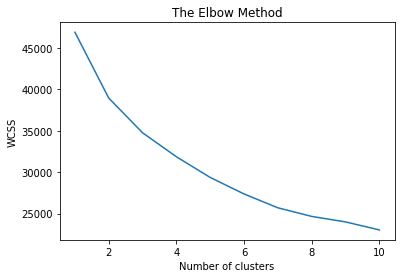

In [11]:
train_df=train_preprocessing_pipeline(x_train, y_train)
test_df=test_preprocessing_pipeline(x_test, y_test)

In [12]:
train_df['Cluster'].unique()

array([1, 3, 2, 0], dtype=int32)

In [13]:
def get_best_param_xgb(x_train, y_train, x_test, y_test):
  best_params={}

  param1={'eta' : [i/100 for i in range(1,20)]}
  param2={'max_depth' : range(3,10,1)}
  param3={'gamma' : [i/10 for i in range(1,10)]}
  param4={'subsample':[i/100.0 for i in range(70,100,5)]}
  param5={'colsample_bytree':[i/100.0 for i in range(70,100,3)]}
  param6={'alpha' : np.arange(0.1, 10, 0.1)}
  param7={'n_estimators':range(10,100,5)}

  parameters=[param1, param2, param3, param4, param5, param6, param7]

  for param in parameters:
    grid=GridSearchCV(XGBRegressor(objective='reg:squarederror'), param, cv=5, n_jobs=-1)
    grid.fit(x_train, y_train)
    best_params.update(grid.best_params_)

  eta=best_params['eta']
  max_depth=best_params['max_depth']
  gamma=best_params['gamma']
  subsample=best_params['subsample']
  colsample_bytree=best_params['colsample_bytree']
  alpha=best_params['eta']
  n_estimators=best_params['n_estimators']

  model=XGBRegressor(objective='reg:squarederror', eta=eta, max_depth=max_depth,  gamma=gamma, subsample=subsample, colsample_bytree=colsample_bytree, alpha=alpha, n_estimators=n_estimators)
  model.fit(x_train, y_train)
  y_pred=model.predict(x_test)

  r2=r2_score(y_test, y_pred)
  return model, r2
  # print('R2_score', r2_score(test_0_y, y_pred))
  # print('RMSE', np.sqrt(mean_squared_error(test_0_y, y_pred)))


In [14]:
def get_best_param_rf(x_train, y_train, x_test, y_test):
    best_params={}

    param1={'criterion': ['squared_error', 'absolute_error']}
    param2={'max_depth' : range(3,10,1)}
    param3={'max_features' : [i/100.0 for i in range(70,100,3)]}
    param4={'max_samples' : [i/100.0 for i in range(70,100,5)]}
    param5={'n_estimators':range(10,100,5)}


    parameters=[param1, param2, param3, param4, param5]

    for param in parameters:
      grid=GridSearchCV(RandomForestRegressor(), param, cv=5, n_jobs=-1)
      grid.fit(x_train, y_train)
      best_params.update(grid.best_params_)

    criterion=best_params['criterion']
    max_depth=best_params['max_depth']
    max_features=best_params['max_features']
    max_samples=best_params['max_samples']
    n_estimators=best_params['n_estimators']



    model=RandomForestRegressor(criterion=criterion, max_depth = max_depth, max_features = max_features, max_samples = max_samples, n_estimators = n_estimators)
    model.fit(x_train, y_train)
    y_pred=model.predict(x_test)

    r2=r2_score(y_test, y_pred)
    return model, r2


In [15]:
clusters=np.sort(train_df['Cluster'].unique())

for i in clusters:
    train=train_df[train_df['Cluster']==i]
    test=test_df[test_df['Cluster']==i]


    train_x=train.drop(columns=['Item_Outlet_Sales', 'Cluster'])
    train_y=train['Item_Outlet_Sales']

    test_x=test.drop(columns=['Item_Outlet_Sales', 'Cluster'])
    test_y=test['Item_Outlet_Sales']

    model_xgb, r2_xgb = get_best_param_xgb(train_x, train_y, test_x, test_y)
    model_rf, r2_rf = get_best_param_rf(train_x, train_y, test_x, test_y)

    if r2_xgb > r2_rf :
      best_model, best_model_name = model_xgb, 'XGB'
    else:
      best_model, best_model_name = model_rf, 'RF'
    
    print(f'Cluster : {i}  r2_xgb = {r2_xgb}  r2_rf = {r2_rf}')

    if not os.path.isdir('Models'):
      os.mkdir('Models')
    pickle.dump(best_model, open(f'Models/{best_model_name+str(i)}.pickle', 'wb'))



Cluster : 0  r2_xgb = 0.6466111820141753  r2_rf = 0.6301848253397073
Cluster : 1  r2_xgb = 0.49763755153811384  r2_rf = 0.48675254681870084
Cluster : 2  r2_xgb = 0.6501800223245447  r2_rf = 0.65448098545179
Cluster : 3  r2_xgb = 0.45192535617040464  r2_rf = 0.4598933796629221
